<a href="https://colab.research.google.com/github/Ki6an/Machine_Learning_Projects/blob/master/Attention/Seq2seq/Seq2Seq_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing relevent libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas
import spacy                          # https://spacy.io/usage/spacy-101
from spacy.lang.en import English
from spacy.lang.de import German
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm_notebook
import random
from collections import Counter

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
# preprocessing 

# Reading the English-German sentences pairs from the file
with open("/content/drive/My Drive/Machine Learning /Projects/seq2seq_attention/deu.txt","r+") as file:
  deu = [x[:-1] for x in file.readlines()]   # x[:-1] -> removes the nextline 

en = []
de = []
for line in deu:
  en.append(line.split("\t")[0])
  de.append(line.split("\t")[1])

In [3]:
#Setting the number of training sentences we'll use
training_examples = 10_000

#We'll be using the spaCy's English and German tokenizers
spacy_en = English()
spacy_de = German()

In [4]:
en_words = Counter()
de_words = Counter()
en_inputs = []
de_inputs = []

#Tokenizing the English and German sentences and creating our word banks for both languages
for i in tqdm_notebook(range(training_examples)):
    en_tokens = spacy_en(en[i])
    de_tokens = spacy_de(de[i])
    if len(en_tokens)==0 or len(de_tokens)==0:      
        continue                                   # if the token is empty go to the start of the loop
    for token in en_tokens:
        en_words.update([token.text.lower()])
    en_inputs.append([token.text.lower() for token in en_tokens] + ['_EOS'])
    for token in de_tokens:
        de_words.update([token.text.lower()])
    de_inputs.append([token.text.lower() for token in de_tokens] + ['_EOS'])

print(en_inputs)
print(de_inputs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[['hi', '.', '_EOS'], ['hi', '.', '_EOS'], ['run', '!', '_EOS'], ['wow', '!', '_EOS'], ['wow', '!', '_EOS'], ['fire', '!', '_EOS'], ['help', '!', '_EOS'], ['help', '!', '_EOS'], ['stop', '!', '_EOS'], ['wait', '!', '_EOS'], ['go', 'on', '.', '_EOS'], ['hello', '!', '_EOS'], ['i', 'ran', '.', '_EOS'], ['i', 'see', '.', '_EOS'], ['i', 'see', '.', '_EOS'], ['i', 'try', '.', '_EOS'], ['i', 'won', '!', '_EOS'], ['i', 'won', '!', '_EOS'], ['smile', '.', '_EOS'], ['cheers', '!', '_EOS'], ['freeze', '!', '_EOS'], ['freeze', '!', '_EOS'], ['got', 'it', '?', '_EOS'], ['got', 'it', '?', '_EOS'], ['got', 'it', '?', '_EOS'], ['he', 'ran', '.', '_EOS'], ['he', 'ran', '.', '_EOS'], ['hop', 'in', '.', '_EOS'], ['hug', 'me', '.', '_EOS'], ['hug', 'me', '.', '_EOS'], ['hug', 'me', '.', '_EOS'], ['i', 'fell', '.', '_EOS'], ['i', 'fell', '.', '_EOS'], ['i', 'fell', '.', '_EOS'], ['i', 'fell', '.', '_EOS'], ['i', 'fell', '.', '_EOS'], ['i', 'know', '.', '_EOS'], ['i', 'lied', '.', '_EOS'], ['i', 'lost', '

In [5]:
# Assigning an index to each word token, including the Start Of String(SOS), End Of String(EOS) and Unknown(UNK) tokens

en_words = ['_SOS','_EOS','_UNK'] + sorted(en_words, key=en_words.get, reverse=True)
en_w2i = {o:i for i,o in enumerate(en_words)}
en_i2w = {i:o for i,o in enumerate(en_words)}

de_words = ['_SOS','_EOS','_UNK'] + sorted(de_words, key=de_words.get, reverse=True)
de_w2i = {o:i for i,o in enumerate(de_words)}
de_i2w = {i:o for i,o in enumerate(de_words)}

In [6]:
#Converting our English and German sentences to their token indexes

for i in range(len(en_inputs)):
    en_sentence = en_inputs[i]
    de_sentence = de_inputs[i]
    en_inputs[i] = [en_w2i[word] for word in en_sentence]
    de_inputs[i] = [de_w2i[word] for word in de_sentence]

In [7]:
en_inputs[:10]

[[525, 3, 1],
 [525, 3, 1],
 [159, 19, 1],
 [1054, 19, 1],
 [1054, 19, 1],
 [457, 19, 1],
 [57, 19, 1],
 [57, 19, 1],
 [61, 19, 1],
 [89, 19, 1]]

**Next we'll be defining our Encoder, Bahdanau Attention Decoder, Luong Attention Decoder and the Attention class for the Luong Decoder.**

In [8]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, drop_prob=0):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=drop_prob, batch_first=True)

    def forward(self, inputs, hidden):
        #Embed input words
        embedded = self.embedding(inputs)
        #Pass the embedded word vectors into LSTM and return all outputs
        output, hidden = self.lstm(embedded, hidden)
        return output, hidden

    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))

In [9]:
class BahdanauDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, drop_prob=0.1):
        super(BahdanauDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size*2, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        encoder_outputs = encoder_outputs.squeeze()
        #Embed input words
        embedded = self.embedding(inputs).view(1, -1)
        embedded = self.dropout(embedded)

        #Calculating Alignment Scores
        x = torch.tanh(self.fc_hidden(hidden[0])+self.fc_encoder(encoder_outputs))
        alignment_scores = x.bmm(self.weight.unsqueeze(2))  # one to one mat multiplication 

        #Softmaxing alignment scores to get Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        #Multiplying the Attention weights with encoder outputs to get the context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        #Concatenating context vector with embedded input word
        output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)

        #Passing the concatenated vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)

        #Passing the LSTM output through a Linear layer acting as a classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        
        return output, hidden, attn_weights

In [10]:
class LuongDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, attention, n_layers=1, drop_prob=0.1):
        super(LuongDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        #Our Attention Mechanism is defined in a separate class
        self.attention = attention

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.classifier = nn.Linear(self.hidden_size*2, self.output_size)
    
    def forward(self, inputs, hidden, encoder_outputs):
        #Embed input words
        embedded = self.embedding(inputs).view(1,1,-1)
        embedded = self.dropout(embedded)

        #Passing previous output word (embedded) and hidden state into LSTM cell
        lstm_out, hidden = self.lstm(embedded, hidden)

        #Calculating Alignment Scores - see Attention class for the forward pass function
        alignment_scores = self.attention(hidden[0], encoder_outputs)

        #Softmaxing alignment scores to obtain Attention weights
        attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)

        #Multiplying Attention weights with encoder outputs to get context vector
        context_vector = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs)

        #Concatenating output from LSTM with context vector
        output = torch.cat((lstm_out, context_vector),-1)

        #Pass concatenated vector through Linear layer acting as a Classifier
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        
        return output, hidden, attn_weights

In [11]:
class Attention(nn.Module):
    def __init__(self, hidden_size, method="dot"):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        #Defining the layers/weights required depending on alignment scoring method
        if method == "general":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)

        elif method == "concat":
            self.fc = nn.Linear(hidden_size, hidden_size, bias=False)
            self.weight = nn.Parameter(torch.FloatTensor(1, hidden_size))
  
    def forward(self, decoder_hidden, encoder_outputs):
        if self.method == "dot":
          #For the dot scoring method, no weights or linear layers are involved
          return encoder_outputs.bmm(decoder_hidden.view(1,-1,1)).squeeze(-1)
    
        elif self.method == "general":
            #For general scoring, decoder hidden state is passed through linear layers to introduce a weight matrix
            out = self.fc(decoder_hidden)
            return encoder_outputs.bmm(out.view(1,-1,1)).squeeze(-1)

        elif self.method == "concat":
            #For concat scoring, decoder hidden state and encoder outputs are concatenated first
            out = torch.tanh(self.fc(decoder_hidden+encoder_outputs))
            return out.bmm(self.weight.unsqueeze(-1)).squeeze(-1)

In [12]:
hidden_size = 256
encoder = EncoderLSTM(len(en_words), hidden_size).to(device)
attn = Attention(hidden_size,"concat")
decoder = LuongDecoder(hidden_size,len(de_words),attn).to(device)

lr = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

In [13]:
EPOCHS = 10
teacher_forcing_prob = 0.5
encoder.train()
decoder.train()
tk0 = tqdm_notebook(range(1,EPOCHS+1),total=EPOCHS)

for epoch in tk0:
    avg_loss = 0.
    tk1 = tqdm_notebook(enumerate(en_inputs),total=len(en_inputs),leave=False)
    for i, sentence in tk1:
        loss = 0.
        h = encoder.init_hidden()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        inp = torch.tensor(sentence).unsqueeze(0).to(device)
        encoder_outputs, h = encoder(inp,h)
        
        #First decoder input will be the SOS token
        decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
        #First decoder hidden state will be last encoder hidden state
        decoder_hidden = h
        output = []
        teacher_forcing = True if random.random() < teacher_forcing_prob else False
        
        for ii in range(len(de_inputs[i])):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            #Get the index value of the word with the highest score from the decoder output
            top_value, top_index = decoder_output.topk(1)
            if teacher_forcing:
                decoder_input = torch.tensor([de_inputs[i][ii]],device=device)
            else:
                decoder_input = torch.tensor([top_index.item()],device=device)
            output.append(top_index.item())
            #Calculate the loss of the prediction against the actual word
            loss += F.nll_loss(decoder_output.view(1,-1), torch.tensor([de_inputs[i][ii]],device=device))
        loss = loss/len(de_inputs[i])
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        avg_loss += loss.item()/len(en_inputs)
    tk0.set_postfix(loss=avg_loss)
    #Save model after every epoch (Optional)
    torch.save({"encoder":encoder.state_dict(),"decoder":decoder.state_dict(),"e_optimizer":encoder_optimizer.state_dict(),
                "d_optimizer":decoder_optimizer},"./model.pt")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


**Using our trained model, let’s visualise some of the outputs that the model produces and the attention weights the model assigns to each input element.**

English: tom 's elderly . _EOS
Predicted: tom ist schon etwas fertig .
Actual: tom ist schon etwas älter . _EOS


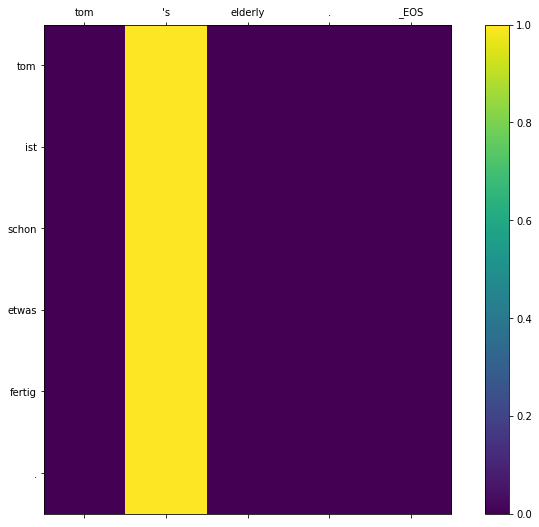

In [14]:
encoder.eval()
decoder.eval()
#Choose a random sentences
i = random.randint(0,len(en_inputs)-1)
h = encoder.init_hidden()
inp = torch.tensor(en_inputs[i]).unsqueeze(0).to(device)
encoder_outputs, h = encoder(inp,h)

decoder_input = torch.tensor([en_w2i['_SOS']],device=device)
decoder_hidden = h
output = []
attentions = []
while True:
    decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
    _, top_index = decoder_output.topk(1)
    decoder_input = torch.tensor([top_index.item()],device=device)
    #If the decoder output is the End Of Sentence token, stop decoding process
    if top_index.item() == de_w2i["_EOS"]:
        break
    output.append(top_index.item())
    attentions.append(attn_weights.squeeze().cpu().detach().numpy())
print("English: "+ " ".join([en_i2w[x] for x in en_inputs[i]]))
print("Predicted: " + " ".join([de_i2w[x] for x in output]))
print("Actual: " + " ".join([de_i2w[x] for x in de_inputs[i]]))

#Plotting the heatmap for the Attention weights
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.array(attentions))
fig.colorbar(cax)
ax.set_xticklabels(['']+[en_i2w[x] for x in en_inputs[i]])
ax.set_yticklabels(['']+[de_i2w[x] for x in output])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()